# Quantum state learning strawberry fields

In [1]:
from qutip import *
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors, colorbar, cm
import time
from tqdm.notebook import tqdm

In [2]:
def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density matrix for
    a harmonic oscillator mode.
    """
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))

    if isket(rho):  # ket状態を密度関数にする（必要かわからん）
        rho = ket2dm(rho)
    
    scale = np.sqrt(2)
    xvec = np.linspace(-5*scale,5*scale,100)

    W = wigner(rho, xvec, xvec)
    wlim = abs(W).max()

    ax.contourf(xvec/scale, xvec/scale, W, 60, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('RdBu'))
    ax.set_xlabel('q', fontsize=16)
    ax.set_ylabel('p', fontsize=16)
    ax.axis("off")
    #ax.set_title()
    fig.tight_layout
    
    return fig, ax

まずは1-moodeのQNNを構成する

In [3]:
def variational_quantum_circuit(params):
    # Gate layer: R-S-R-D-K
    def layer(i, q):
        Rgate(params[i*7+0])                | q
        Sgate(params[i*7+1], params[i*7+2]) | q
        Rgate(params[i*7+3])                | q
        Dgate(params[i*7+4], params[i*7+5]) | q
        Kgate(params[i*7+6])                | q
        return q
    
    # Start SF program
    prog = sf.Program(1)

    # construct the circuit
    with prog.context as q:
        Vacuum() | q
        for k in range(depth):
            q = layer(k, q)
    
    eng = sf.Engine("fock", backend_options={"cutoff_dim": dim})
    state = eng.run(prog).state
    ket = state.ket()
    return ket

cost関数を定義。ここでは以下の関数とする。

$C(\theta) = |1-\langle \Psi_{t}|U(\theta)|0\rangle|$

In [4]:
def cost(target_state, ket): # target_stateとketはnumpy.ndarrayを想定している
    # fidelityを計算
    inner_product = np.conjugate(target_state.T) @ ket
    return abs(1 - inner_product)

In [5]:
def get_cost(params):
    state = variational_quantum_circuit(params)
    c = cost(target_state, state)
    return c

ターゲットを生成

[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


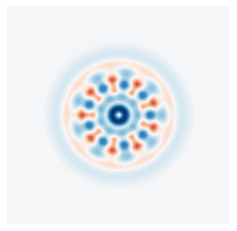

In [113]:
dim = 30
target_state = np.zeros(dim)
target_state[0] = 1
target_state[9] = 1
target_state = target_state / (np.conjugate(target_state.T) @ target_state) # 規格化
plot_wigner(Qobj(target_state))
print(target_state)

In [116]:
# callback用の関数
def callback(params):
    params_history.append(params)
    co = get_cost(params)
    cost_history.append(co)
    print('cost', co)

最適化を行う

cost 0.5063555254236215
cost 0.5055735064413757
cost 0.5043563280630569
cost 0.5023158944581606
cost 0.49964647681301333
cost 0.4987993490345161
cost 0.4899799128247031
cost 0.4898229057830052
cost 0.4895761429011071
cost 0.4891740757748173
cost 0.48577038091516545
cost 0.47944283428588313
cost 0.474495541456629
cost 0.4686486932861644
cost 0.4558805259625776
cost 0.45210200414589646
cost 0.44873721019871937
cost 0.44404240461364586
cost 0.43846974196426464
cost 0.4285695364174768
cost 0.42303907156487613
cost 0.4149688400686272
cost 0.41366071524772
cost 0.41122598811768013
cost 0.39286235080542037
cost 0.37063250339008896
cost 0.36498323499688906
cost 0.36104499390811734
cost 0.3556926781715579
cost 0.3504180750660758
cost 0.34220829440397277
cost 0.33288748615341057
cost 0.3262891841386962
cost 0.32476560558229906
cost 0.32200550511857806
cost 0.3176356003855988
cost 0.31362173125478604
cost 0.3117043865240103
cost 0.31102680339760086
cost 0.309875793614953
cost 0.3083568612683375
c

cost 0.2964382029178338
cost 0.29643637611807416
cost 0.2964352609534926
cost 0.2964349498100775
cost 0.2964348214865424
cost 0.29643474730563
cost 0.2964346588953158
cost 0.29643454068179464
cost 0.29643434864530116
cost 0.29643405697014097
cost 0.2964336601784148
cost 0.2964331622759668
cost 0.29643251067479354
cost 0.2964322213611117
cost 0.29643176367424007
cost 0.29643112871035016
cost 0.29643079260712196
cost 0.2964303163070622
cost 0.2964295216529894
cost 0.2964283852228562
cost 0.29642658703293745
cost 0.29642395348539696
cost 0.296423180327068
cost 0.2964218064170511
cost 0.2964197048169751
cost 0.2964176443129709
cost 0.29641708782706994
cost 0.2964166385349605
cost 0.2964161006200701
cost 0.2964154464489152
cost 0.2964148316581978
cost 0.29641412712914567
cost 0.2964135436645654
cost 0.2964130116897097
cost 0.2964122311901471
cost 0.2964110113943445
cost 0.2964101584486336
cost 0.2964087756006818
cost 0.29640669469494746
cost 0.29640488021637684
cost 0.29640357547013707
cost

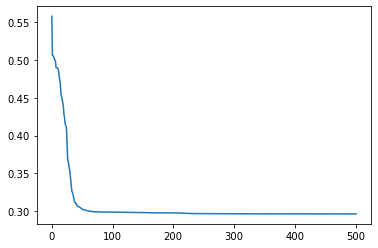

In [118]:
depth = 10

# 学習
params = np.random.normal(0, 0.1, [7*depth]) # 最初のパラメータ
maxiter = 501

params_history = []
cost_history = []
cost_history.append(get_cost(params))

method = "BFGS"
options = {"disp": True, "maxiter": maxiter}
count = 0

start = time.perf_counter()
opt = scipy.optimize.minimize(get_cost, params, method='BFGS',
                              callback=lambda x: callback(x), options=options)
end = time.perf_counter()

print('time', end - start, 's')
nit = opt['nit']
plt.plot(np.linspace(0, nit, nit+1), cost_history)
plt.show()

In [119]:
cost_history_np = np.array(cost_history)
fid = (1-cost_history_np.min())**2
amin = cost_history_np.argmin()
print(amin, fid)

501 0.4952138950317642


In [120]:
# save data
cost_history_np = np.array(cost_history)
params_history_np = np.array(params_history)
library = 'strawberryfields'
optname = '_scipyminimize'
statename = '_ON9'
cpuname = 'intel_core_i7_11gen'
savename = 'QNN_'+library+optname+statename
np.save(savename+'_cost', cost_history_np)
np.save(savename+'_params', params_history_np)
fid = (1-cost_history_np.min())**2
amin = cost_history_np.argmin()
f = open(savename+'.txt', 'a')
f.write('\n')
datalist = ['CPU: '+cpuname+'\n', savename+statename+'\n', 'Cutoff dimention: '+str(dim)+'\n', 
            'Runtime: '+str(end-start)+'s\n', 'Fidelity: '+str(fid)+'\n', 'argmin: '+str(amin)+'\n']
f.writelines(datalist)
f.close()
print(amin, fid)
print(savename)

501 0.4952138950317642
QNN_strawberryfields_scipyminimize_ON9


91 0.9998807492350781


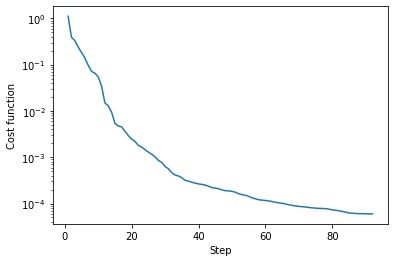

In [121]:
co = np.load('QNN_strawberryfields_scipyminimize_fock1_cost.npy')
print(co.argmin(), (1-co[co.argmin()])**2)
plt.plot(np.linspace(1, len(co), len(co)), co)
#plt.xlim([-50,1050])
plt.xlabel('Step')
plt.ylabel('Cost function')
plt.yscale('log')
plt.show()

501
[ 7.10517267e-01+0.00098119j  1.14188676e-02+0.0008881j
 -8.89119958e-04-0.02126317j -1.75132604e-04+0.00040366j
 -5.75136694e-04-0.00244606j  7.06266647e-03+0.00902119j
 -3.39194579e-04-0.00021149j -1.02083104e-02+0.01729663j
  7.24590225e-03-0.00912124j  6.96911626e-01-0.00051846j
  6.67045127e-03+0.01153577j  1.21558343e-02-0.00664094j
  5.33998847e-03+0.01076958j  1.21116134e-02-0.00494112j
  1.53860461e-02-0.00667881j -7.99599224e-03-0.00050425j
 -3.09952536e-03-0.00858571j -1.77596099e-02+0.00014812j
  5.78548568e-04+0.008187j   -1.68387059e-02+0.01436818j
  2.97365966e-03-0.003382j    2.12404080e-02-0.00983334j
 -1.02760189e-02-0.02285759j  2.77512609e-03+0.00175212j
  1.94392529e-03-0.01133256j -1.23462945e-02+0.00386275j
 -6.74940973e-03-0.00021649j  1.47386826e-03+0.0064615j
 -1.01585002e-02-0.00034536j  4.47122494e-03+0.00679848j]


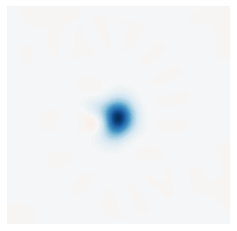

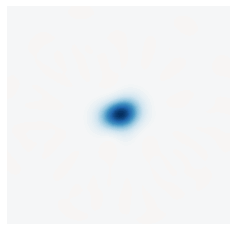

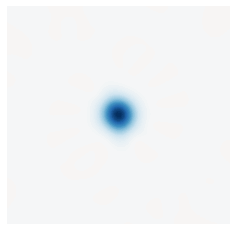

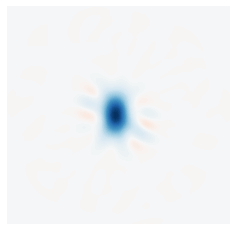

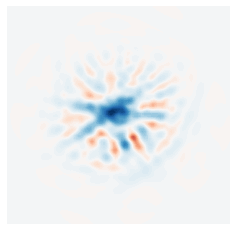

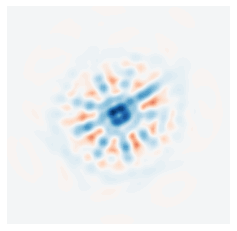

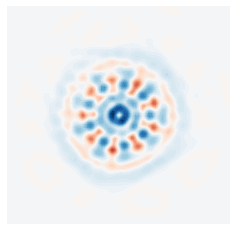

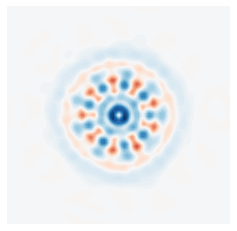

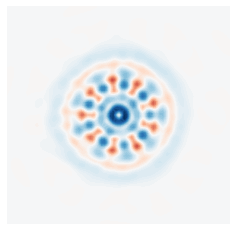

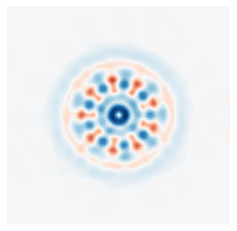

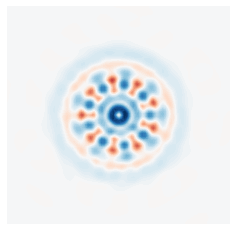

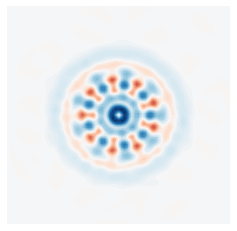

In [123]:
depth = 10
dim = 30
par = np.load('QNN_strawberryfields_scipyminimize_ON9_params.npy')
print(len(par))
plot_list = [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, len(par)-1]#, 100]

for i in plot_list:
    sta = variational_quantum_circuit(par[i])
    plot_wigner(Qobj(sta))
print(sta)

In [77]:
print(par[-1])

[ 0.12409535  0.09330725  0.01953345 -0.10325408  0.07334302  0.10083471
  0.11072314 -0.0358967   0.23601978 -0.11606336 -0.37236341  0.31924461
  0.13676704 -0.08689177  0.07785514  0.12389943 -0.16912262 -0.07275705
  0.30096381  0.11389685  0.26839652  0.03883124  0.07284506 -0.07845497
  0.1007105   0.38920561  0.0005587   0.14111459  0.18167533  0.30358779
 -0.17398006 -0.05290487 -0.3172268  -0.01934977  0.15028543 -0.08966891
  0.14473037 -0.01754232 -0.21425626  0.03741009  0.14425529  0.16828568
 -0.19880201  0.13189979  0.17736463 -0.04966916  0.30117752 -0.33148305
  0.27654915 -0.07063206  0.08969285  0.09815626 -0.07052298  0.34096959
 -0.25781592 -0.21878017]
